In [ ]:
import pandas as pd
import numpy as np
import networkx as nx

from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination, CausalInference
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, HillClimbSearch
from pgmpy.metrics import structure_score
from pgmpy.utils import get_example_model
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


Bem vindos à atividade sobre REDES BAYESIANAS <3 <3
Vamos usar a biblioteca pgmpy para facilitar a manipulação das RBs. Provavelmente vocês terão que instalar essa biblioteca e talvez passar um pouquinho de raiva com problemas de compatibilidade até fazer funcionar. *Ninguém mandou fazer engenharia*.


# PARTE 1: REDE ASIA E INFERÊNCIA PROBABILÍSTICA

A nossa rede de interesse é uma rede benchmark, chamada ASIA. Ela modela (teoricamente) fatores de risco relacionados à tuberculose e outros problemas que podem afetar o pulmão, como câncer e cigarro. Podemos interpretá-la aqui como uma rede causal. 

Ao longo da atividade, você encontrará partes de código para completar, resultados para analisar, e perguntas teóricas para responder. Leia tudo com atenção!

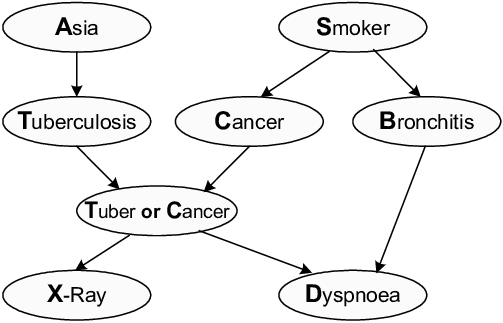

Tirem um minutinho para observar a rede. Quais independências condicionais você identifica?
Caso não tenhamos nenhuma evidência, as variáveis Asia e Smoker estão d-separadas ou d-conectadas? Qual variável teríamos que observar para mudar isso?

In [897]:

asia = get_example_model("asia")

inference = VariableElimination(asia)
prob_tub = inference.query(variables=["tub"], evidence={'asia': 'yes'})
print(prob_tub)

print("Nós:", asia.nodes())
print("Arestas:", asia.edges())


+----------+------------+
| tub      |   phi(tub) |
+==========+============+
| tub(yes) |     0.0500 |
+----------+------------+
| tub(no)  |     0.9500 |
+----------+------------+
Nós: ['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']
Arestas: [('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')]


In [898]:
prob = inference.query(variables=['tub'], evidence={'dysp': 'yes'})
print(prob)


+----------+------------+
| tub      |   phi(tub) |
+==========+============+
| tub(yes) |     0.0188 |
+----------+------------+
| tub(no)  |     0.9812 |
+----------+------------+


In [899]:
prob = inference.query(variables=['tub'], evidence={'lung': 'no'})
print(prob)

+----------+------------+
| tub      |   phi(tub) |
+==========+============+
| tub(yes) |     0.0104 |
+----------+------------+
| tub(no)  |     0.9896 |
+----------+------------+


Vamos brincar um pouco com inferência. A ideia é usar pgmpy para fazer perguntas de probabilidade condicional.

1. Encontre alguma configuração de evidências que aumente a probabilidade de tuberculose.
2. Escolha 2 independências condicionais verificadas por d-separação e mostre que elas são verdadeiras fazendo a inferência.

# PARTE 2: APRENDIZADO ESTRUTURAL E CLASSIFICAÇÃO DE DADOS

Vamos agora carregar alguns dados, ou seja, observações das variáveis da rede, e fazer alguns testes. Estamos interessados, por exemplo, em saber se podemos estimar uma rede boa o bastante, usando algum algoritmo de aprendizado de RBs, e comparar a rede estimada com a rede real.

In [900]:
# carregando o dataset

data = pd.read_csv("asia10K.csv")
data = data.replace({'yes': 1, 'no': 0})
data.rename(columns={
    'Smoker': 'smoke',
    'LungCancer': 'lung',
    'VisitToAsia': 'asia',
    'Tuberculosis': 'tub',
    'TuberculosisOrCancer': 'either',
    'X-ray': 'xray',
    'Bronchitis': 'bronc',
    'Dyspnea': 'dysp'
}, inplace=True)

/tmp/ipykernel_13347/1461063055.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace({'yes': 1, 'no': 0})


In [901]:
data.shape

(10000, 8)

In [902]:
data.head()

,smoke,lung,asia,tub,either,xray,bronc,dysp
0,1,1,0,0,1,1,1,1
1,0,0,0,0,0,1,1,1
2,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,1,1
4,1,0,0,0,0,0,1,0


Vamos invocar o algoritmo Hill Climbing (HC) para aprender uma rede a partir desses dados.
Como o HC funciona?
Quais suas vantagens e limitações?

In [903]:
est = HillClimbSearch(data)
model = est.estimate(scoring_method="bicscore")

  0%|          | 13/1000000 [00:00<4:39:33, 59.62it/s]


In [904]:
model.edges()

OutEdgeView([('smoke', 'tub'), ('tub', 'lung'), ('tub', 'asia'), ('either', 'lung'), ('either', 'xray'), ('either', 'tub'), ('either', 'smoke'), ('bronc', 'smoke'), ('bronc', 'either'), ('dysp', 'bronc'), ('dysp', 'either')])

Provavelmente, as arestas do modelo estimado não são as mesmas que a rede real. Por que isso aconteceu?

O modelo identificou outras arestas que o modelo teórico não mostrou. Os dados apresentaram correlação frente ao banco de dados disponível.

Vamos agora ver como usar RBs para classificação de dados e comparar a rede real e uma rede estimada. Para isso, vamos imaginar um cenário em que temos poucos dados.

In [905]:
poucos_dados = data.sample(n=100, random_state=42)

Separe os dados em treino e teste. Vamos usar a parte de treino para estimar uma RB usando HC, e o teste para medir a acurácia de classificação. 
Nossa variável alvo será a predição de bronquite.

In [ ]:
# separe os dados em treino e teste
train_data, test_data = train_test_split(poucos_dados, test_size=0.3, random_state=42)

In [907]:
# estime uma RB usando HC nos dados de treino
est = HillClimbSearch(train_data)
model_treino = est.estimate(scoring_method="bicscore", tabu_length=1000)

  0%|          | 6/1000000 [00:00<5:23:00, 51.60it/s]


Ao estimar uma RB usando HC com poucos dados, é comum que alguma variável acabe ficando de fora. No caso da rede ASIA, é comum que a variável A não entre no DAG, pois ela apresenta uma correlação mais fraca com as demais. Verifique se é o caso. Caso aconteça, não se preocupe, vamos trabalhar com o DAG do jeito que o algoritmo retornar mesmo.

In [908]:
model_treino.edges()

OutEdgeView([('either', 'lung'), ('either', 'xray'), ('either', 'tub'), ('bronc', 'smoke'), ('dysp', 'bronc'), ('dysp', 'either')])

O algoritmo HC nos dá a estrutura (topologia) da rede, mas não os seus parâmetros (as distribuições de probabilidade). Precisamos dos parâmetros para fazer inferência e classificar dados, então vamos usar a pgmpy para obtê-los.

In [909]:
model_treino = BayesianNetwork(model_treino.edges()) # isso é necessário para criar o modelo pgmpy
model_treino.fit(train_data, estimator=MaximumLikelihoodEstimator) # aqui estimamos os parâmetros

In [910]:
# verificar quais são as variáveis presentes no modelo
set_of_variables = set()
for edge in model_treino.edges():
    set_of_variables.add(edge[0])
    set_of_variables.add(edge[1])

In [911]:
set_of_variables

{'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub', 'xray'}

In [912]:
# inferência
inference = VariableElimination(model_treino)
target = "bronc"

model_vars = set(model_treino.nodes())
evidence_vars = [c for c in test_data.columns if c in model_vars and c != target]

predicted_labels = []
for i in range(test_data.shape[0]):
    evidence = test_data.iloc[i][evidence_vars].to_dict()

    # converte eventuais 'yes'/'no' residuais para 0/1
    evidence = {k: (1 if v == "yes" else 0 if v == "no" else v) for k, v in evidence.items()}

    q = inference.query(variables=[target], evidence=evidence)

    # q.values = [P(bronc=0), P(bronc=1)]
    pred = int(np.argmax(q.values))  # escolhe 0 ou 1
    predicted_labels.append(pred)

predicted_labels = np.array(predicted_labels)

In [ ]:
# vamos medir as métricas de acurácia de classificação
assert len(test_data) == len(predicted_labels), (len(test_data), len(predicted_labels))

accuracy  = accuracy_score(test_data['bronc'], predicted_labels)
precision = precision_score(test_data['bronc'], predicted_labels, zero_division=0)
recall    = recall_score(test_data['bronc'], predicted_labels, zero_division=0)
f1        = f1_score(test_data['bronc'], predicted_labels, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")
print("\nMatriz de confusão:\n", confusion_matrix(test_data['bronc'], predicted_labels))
print("\nRelatório de classificação:\n", classification_report(test_data['bronc'], predicted_labels, digits=4, zero_division=0))

Accuracy:  0.8667
Precision: 1.0000
Recall:    0.7647
F1:        0.8667

Matriz de confusão:
 [[13  0]
 [ 4 13]]

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.7647    1.0000    0.8667        13
           1     1.0000    0.7647    0.8667        17

    accuracy                         0.8667        30
   macro avg     0.8824    0.8824    0.8667        30
weighted avg     0.8980    0.8667    0.8667        30



----------------------------------------------------------


In [914]:
# Vamos agora fazer a mesma inferência, mas usando a rede Asia original.
asia_original = get_example_model("asia")
asia_original.edges()

OutEdgeView([('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')])

In [915]:
# A rede original no pgmpy usa 'yes' e 'no' como valores das variáveis, então precisamos ajustar os dados de teste
test_data = test_data.replace({1: 'yes', 0: 'no'})

In [916]:
# verificar quais são as variáveis presentes no modelo
set_of_variables = set()
for edge in asia_original.edges():
    set_of_variables.add(edge[0])
    set_of_variables.add(edge[1])

set_of_variables

{'asia', 'bronc', 'dysp', 'either', 'lung', 'smoke', 'tub', 'xray'}

In [917]:
# inferência
inference = VariableElimination(asia_original)
target = "bronc"

model_vars = set(asia_original.nodes())
evidence_vars = [c for c in test_data.columns if c in model_vars and c != target]

predicted_labels = []
for i in range(test_data.shape[0]):
    evidence = test_data.iloc[i][evidence_vars].to_dict()

    # converte eventuais 'yes'/'no' residuais para 0/1
    evidence = {k: ('yes' if v == 1 else 'no') for k, v in evidence.items()}

    q = inference.query(variables=[target], evidence=evidence)

    # q.values = [P(bronc=0), P(bronc=1)]
    pred = int(np.argmax(q.values))  # escolhe 0 ou 1
    predicted_labels.append(pred)

predicted_labels = np.array(predicted_labels)

In [918]:
assert len(test_data) == len(predicted_labels), (len(test_data), len(predicted_labels))

# 👇 converte rótulos verdadeiros para 0/1, mantendo o resto igual
y_true = test_data['bronc']
if y_true.dtype == object:
    y_true = y_true.map({'no': 0, 'yes': 1}).astype(int)

y_pred = np.asarray(predicted_labels, dtype=int)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")
print("\nMatriz de confusão:\n", confusion_matrix(y_true, y_pred))
print("\nRelatório de classificação:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))


Accuracy:  0.5667
Precision: 0.5667
Recall:    1.0000
F1:        0.7234

Matriz de confusão:
 [[ 0 13]
 [ 0 17]]

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        13
           1     0.5667    1.0000    0.7234        17

    accuracy                         0.5667        30
   macro avg     0.2833    0.5000    0.3617        30
weighted avg     0.3211    0.5667    0.4099        30



Compare as métricas da rede estimada usando HC e da rede asia original. O que aconteceu? Como você explica esse fenômeno? O que poderia ser feito diferente? Experimente refazer o experimento usando mais dados e veja se algo muda.

In [919]:
muitos_dados = data.sample(n=10000, random_state=42)

train_data, test_data = train_test_split(muitos_dados, test_size=0.3, random_state=42)

# estime uma RB usando HC nos dados de treino
est = HillClimbSearch(train_data)
model_treino_MD_HC = est.estimate(scoring_method="bicscore", tabu_length=1000)

model_treino_MD_HC = BayesianNetwork(model_treino_MD_HC.edges()) # isso é necessário para criar o modelo pgmpy
model_treino_MD_HC.fit(train_data, estimator=MaximumLikelihoodEstimator) # aqui estimamos os parâmetros

# inferência
inference = VariableElimination(model_treino_MD_HC)
target = "bronc"

model_vars = set(model_treino_MD_HC.nodes())
evidence_vars = [c for c in test_data.columns if c in model_vars and c != target]

predicted_labels = []
for i in range(test_data.shape[0]):
    evidence = test_data.iloc[i][evidence_vars].to_dict()

    # converte eventuais 'yes'/'no' residuais para 0/1
    evidence = {k: (1 if v == "yes" else 0 if v == "no" else v) for k, v in evidence.items()}

    q = inference.query(variables=[target], evidence=evidence)

    # q.values = [P(bronc=0), P(bronc=1)]
    pred = int(np.argmax(q.values))  # escolhe 0 ou 1
    predicted_labels.append(pred)

predicted_labels = np.array(predicted_labels)

assert len(test_data) == len(predicted_labels), (len(test_data), len(predicted_labels))

accuracy  = accuracy_score(test_data['bronc'], predicted_labels)
precision = precision_score(test_data['bronc'], predicted_labels, zero_division=0)
recall    = recall_score(test_data['bronc'], predicted_labels, zero_division=0)
f1        = f1_score(test_data['bronc'], predicted_labels, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")
print("\nMatriz de confusão:\n", confusion_matrix(test_data['bronc'], predicted_labels))
print("\nRelatório de classificação:\n", classification_report(test_data['bronc'], predicted_labels, digits=4, zero_division=0))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 10/1000000 [00:00<5:28:11, 50.78it/s]


Accuracy:  0.8500
Precision: 0.8588
Recall:    0.8007
F1:        0.8288

Matriz de confusão:
 [[1461  179]
 [ 271 1089]]

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.8435    0.8909    0.8665      1640
           1     0.8588    0.8007    0.8288      1360

    accuracy                         0.8500      3000
   macro avg     0.8512    0.8458    0.8477      3000
weighted avg     0.8505    0.8500    0.8494      3000



In [ ]:
# Vamos agora fazer a mesma inferência, mas usando a rede Asia original.
asia_original = get_example_model("asia")
asia_original.edges()

# inferência
inference = VariableElimination(asia_original)
target = "bronc"

model_vars = set(asia_original.nodes())
evidence_vars = [c for c in test_data.columns if c in model_vars and c != target]

predicted_labels = []
for i in range(test_data.shape[0]):
    evidence = test_data.iloc[i][evidence_vars].to_dict()

    # converte eventuais 'yes'/'no' residuais para 0/1
    evidence = {k: ('yes' if v == 1 else 'no') for k, v in evidence.items()}

    q = inference.query(variables=[target], evidence=evidence)

    # q.values = [P(bronc=0), P(bronc=1)]
    pred = int(np.argmax(q.values))  # escolhe 0 ou 1
    predicted_labels.append(pred)

predicted_labels = np.array(predicted_labels)

assert len(test_data) == len(predicted_labels), (len(test_data), len(predicted_labels))

# Converte rótulos verdadeiros para 0/1, mantendo o resto igual
y_true = test_data['bronc']
if y_true.dtype == object:
    y_true = y_true.map({'no': 0, 'yes': 1}).astype(int)

y_pred = np.asarray(predicted_labels, dtype=int)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")
print("\nMatriz de confusão:\n", confusion_matrix(y_true, y_pred))
print("\nRelatório de classificação:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))


Accuracy:  0.1500
Precision: 0.1565
Recall:    0.1993
F1:        0.1753

Matriz de confusão:
 [[ 179 1461]
 [1089  271]]

Relatório de classificação:
               precision    recall  f1-score   support

           0     0.1412    0.1091    0.1231      1640
           1     0.1565    0.1993    0.1753      1360

    accuracy                         0.1500      3000
   macro avg     0.1488    0.1542    0.1492      3000
weighted avg     0.1481    0.1500    0.1468      3000



# Discussão

A rede 'Asia_original' foi construído baseado em um modelo teórico em relações gerais e probabilidades fixas de referência. Dessa forma ela não foi ajustada para o conjunto de dados utilizado 'asia10K.csv', portanto não representa as distribuições empíricas do banco de dados. 

Por outro lado a rede Hill Climb foi baseada diretamente no dados fornecidos, maximizando o score de verossimilhança (BIC), capturando correlações específicas incluindo ruídos e relações acidentais. Isso explica um desempenho melhor para previsão de Bronquite.

## Quantidade de Dados

A rede HC manteve um alto desempenho no aumento de dados 86.7% --> 85%, mostrando que a base maior foi capaz de manter uma generalização e não obteve overfitting. 

Entretanto a rede Asia Original piorou drásticamente, de 56.7% --> 15%. Isso mostrou há uma grande divergência entre o modelo teórico e a distribuição empírica à medida que a amostra cresce. 

| Métrica   | HC (poucos) | Asia (poucos) | HC (muitos) | Asia (muitos) |
| --------- | ----------- | ------------- | ----------- | ------------- |
| Accuracy  | 0.8667      | 0.5667        | 0.8500      | 0.1500        |
| Precision | 1.0000      | 0.5667        | 0.8588      | 0.1565        |
| Recall    | 0.7647      | 1.0000        | 0.8007      | 0.1993        |
| F1        | 0.8667      | 0.7234        | 0.8288      | 0.1753        |


## Overfitting

No experimento com poucos dados, a rede aprendida pelo algoritmo Hill Climbing atingiu uma precisão perfeita, acertando todas as vezes em que previu a presença de bronquite. Apesar de parecer um ótimo resultado, isso indica que o modelo se ajustou demais aos dados disponíveis, ficando muito específico aos padrões daquele conjunto. Ele passou a prever apenas quando tinha “certeza”, o que explica a queda no recall e mostra que, com tão poucas amostras, o modelo acabou aprendendo também ruídos e particularidades do treino, perdendo parte da capacidade de generalizar para novos casos.
